In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

# CSV 파일 읽기
df = pd.read_csv('/content/drive/My Drive/daily_chart/daily_chart.csv')

# 'Current Price' 열을 실수형으로 변환
df['Current Price'] = df['Current Price'].astype(float)

# Date 열을 datetime 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Labels 생성 (기준일 다음 날의 종가)
current_price = df['Current Price']
labels = current_price.shift(-1)  # 기준일 다음 날의 종가를 라벨로 사용

# 상승 하락 여부 열 추가 (Direction)
# 다음 날의 가격이 현재 가격보다 크면 1(상승), 아니면 0(하락)
df['Direction'] = (labels > current_price).astype(int)

# 마지막 행의 labels와 Direction은 NaN이므로 제거
df.dropna(subset=['Direction'], inplace=True)

# features와 labels 데이터프레임 생성
features = df.drop(columns=['Date'])  # Direction 열은 features에 포함

# 결과 출력
print("Features DataFrame:")
print(features.head())  # features의 처음 5개 행 출력

print("\nLabels:")
print(labels.head())  # labels의 처음 5개 행 출력

Features DataFrame:
   Start Price  Current Price  High Price  Low Price    Volume  Direction
0        55800        56700.0       56700      55400  19358433          0
1        56700        56300.0       57200      56000  15558208          0
2        57000        56000.0       57300      55500  14180520          0
3        56100        56000.0       56500      55600  12095519          0
4        56100        55500.0       56400      55100   9839252          0

Labels:
0    56300.0
1    56000.0
2    56000.0
3    55500.0
4    55000.0
Name: Current Price, dtype: float64


In [92]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# 시퀀스 길이 설정
sequence_length = 14
pred_days = 1


# 스케일러 인스턴스 생성
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()

# 피처와 라벨을 NumPy 배열로 변환
X = features.to_numpy()  # features를 ndarray로 변환
y = labels.to_numpy()  # labels를 ndarray로 변환

# 라벨을 2D 배열로 변환
y = y.reshape(-1, 1)
# 피처와 라벨에 대해 스케일링 수행
X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_labels.fit_transform(y)

n_train = int(0.9 * len(X_scaled))
#X_train_scaled, X_test_scaled = X_scaled[:n_train], X_scaled[n_train:]
dates_train, dates_test = dates[sequence_length:n_train], dates[n_train:]
#y_train_scaled, y_test_scaled = y_scaled[:n_train], y_scaled[n_train:]

trainX = []
trainY = []
testX = []
testY = []

for i in range(sequence_length, n_train-pred_days + 1):
    trainX.append(X_scaled[i-sequence_length:i, 0:X_scaled.shape[1]])
    trainY.append(y_scaled[i+pred_days-1:i+pred_days, 0])

for i in range(n_train-pred_days+1, len(y_scaled)-pred_days+1):
    testX.append(X_scaled[i-sequence_length:i, 0:X_scaled.shape[1]])
    testY.append(y_scaled[i+pred_days-1:i+pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

# 스케일링된 피처와 라벨 크기 확인
print("훈련 데이터 크기:", trainX.shape)
print("테스트 데이터 크기:", testX.shape)
print("훈련 라벨 크기:", trainY.shape)
print("테스트 라벨 크기:", testY.shape)
print("훈련 날짜 크기", dates_train.shape)
print("테스트 날짜 크기", dates_test.shape)

훈련 데이터 크기: (1066, 14, 6)
테스트 데이터 크기: (120, 14, 6)
훈련 라벨 크기: (1066, 1)
테스트 라벨 크기: (120, 1)
훈련 날짜 크기 (1066,)
테스트 날짜 크기 (120,)


In [93]:
# 첫 번째 LSTM 층
model = Sequential()
model.add(LSTM(100, activation = "tanh", return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
#model.add(LSTM(32, activation = "tanh", return_sequences=False))  # 두 번째 LSTM 층
model.add(LSTM(100, activation = "tanh", return_sequences=False))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(trainY.shape[1]))  # 출력층

# 초기 학습률 설정
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 모델 컴파일
#model.compile(optimizer='adam', loss=directional_accuracy_loss)

# 학습률을 동적으로 조정하는 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-8, verbose=1)

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(trainX, trainY,
                    epochs=200,
                    batch_size=32,
                    validation_data=(testX[:-1], testY[:-1]),
                    callbacks=[reduce_lr])

model.save("my_lstm_model.keras")
model = load_model("my_lstm_model.keras")

# 테스트 데이터에 대한 예측
predY = model.predict(testX)

# 예측값과 실제값 복구
y_test_rescaled = scaler_labels.inverse_transform(testY)  # y_test 복구
y_pred_rescaled = scaler_labels.inverse_transform(predY)  # y_pred 복구

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                       │ (None, 14, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 14, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,301 (481.64 KB)

 Trainable params: 123,301 (481.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4544 - val_loss: 0.0117 - learning_rate: 0.0100
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0072 - learning_rate: 0.0100
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 0.0100
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0035 - learning_rate: 0.0100
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0025 - learning_rate: 0.0100
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0029 - learning_rate: 0.0100
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0031 - learning_rate: 0.0100
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0026 - learning_rate: 0.0100
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0029 - learning_rate: 0.0100
Epoch 10/200
34/34

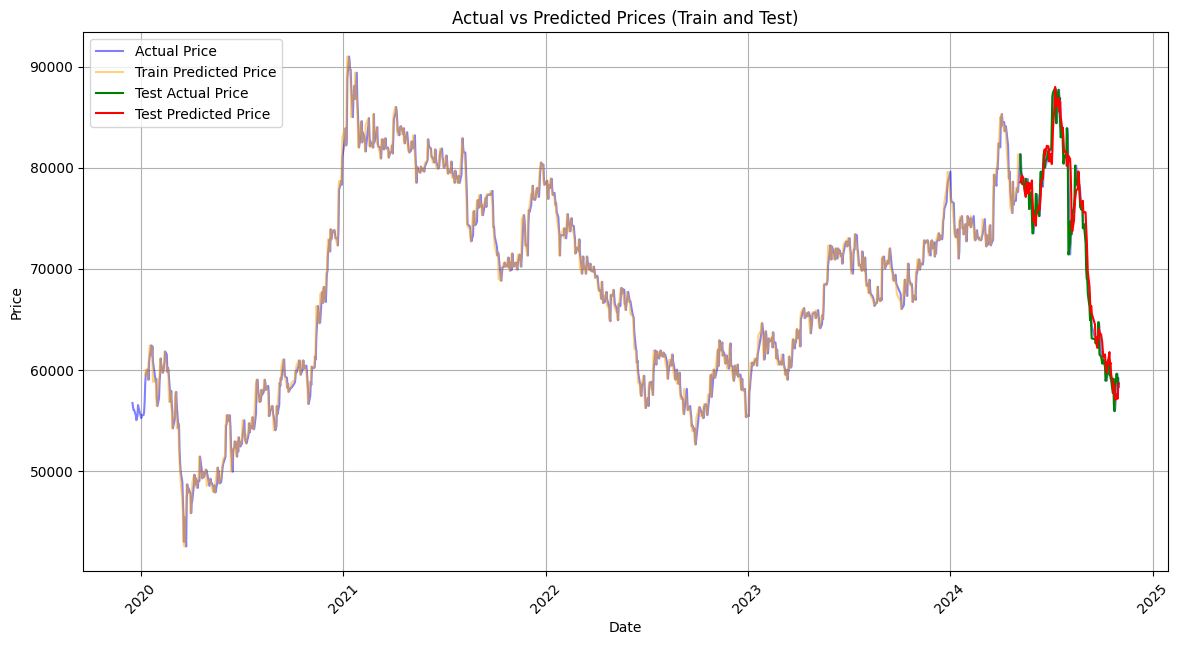

In [94]:
import matplotlib.pyplot as plt

# 전체 데이터 (train + test) 준비
# 실제 가격 (train + test)
all_dates = pd.to_datetime(df['Date'])  # 원본 데이터에서 날짜 가져오기
all_prices = df['Current Price'].values  # 원본 데이터에서 가격 가져오기

# 학습 데이터의 길이
n_train = len(trainY)  # 학습 데이터의 수

# 그래프 생성
plt.figure(figsize=(14, 7))

# 전체 실제 가격 그래프
plt.plot(all_dates, all_prices, label='Actual Price', color='blue', alpha=0.5)

# 학습 데이터의 예측값
plt.plot(dates_train, scaler_labels.inverse_transform(trainY), label='Train Predicted Price', color='orange', alpha=0.5)

# 테스트 데이터의 실제값과 예측값
plt.plot(dates_test, y_test_rescaled, label='Test Actual Price', color='green')
plt.plot(dates_test, y_pred_rescaled, label='Test Predicted Price', color='red')

# 그래프 제목과 레이블 설정
plt.title('Actual vs Predicted Prices (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# 그래프 표시
plt.show()

In [102]:
from sklearn.metrics import r2_score

# R² 점수 계산
r2 = r2_score(y_test_rescaled_clean[:-1], y_pred_rescaled_clean[:-1])

# R² 점수 출력
print(f"R² Score: {r2:.3f}")

R² Score: 0.939
